In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import os
import json
import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm
import sklearn
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

sys.path.insert(0, '/home/sharifullina/thesis/Soft-DTW-Loss/')
from sdtw_cuda_loss import SoftDTW

In [3]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/datasets/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

### Преобразуем данные

In [6]:
wells = os.listdir(target_folder)
required_params_plus = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA', 'WELL']
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [7]:
# X_all - Dataframe with all logging while drilling data concatenated

dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
for i in range(len(dataset_all)):
    dataset_all[i]['WELL'] = wells[i]

dataset = []
for df in dataset_all:
    dataset.append(df[required_params_plus])
    
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

# X_list is a list containing a data for all wells splitted to windows with size 256

X_list = []
for i in range(0, len(X_all) - 256, 10):
    X_list.append(X_all[i : 256 + i])
    
# X_list_minus is X_list but without the WELL column
    
X_list_minus = []
for x in X_list:
    X_list_minus.append(x.loc[:, x.columns != 'WELL'])
    
# X is an array with the shape = (5901, 256, 5)
    
X = []
for i in X_list_minus:
    X.append(i.values)

X = np.dstack(X)
X = np.rollaxis(X, -1)

# map_well_to_label is dictionary to help to rename wells from 'well_N' to N
map_well_to_label = {w:i for i, w in enumerate(wells)}

# label = well's number
y = np.array([map_well_to_label[df['WELL'].iloc[0]] for df in X_list])


### Импортируем verificator, regulator

In [8]:
from dataset import *
from model import * # GAN model
from inceptiontime.src.models.inception import InceptionModel # Verificator
# Regulator
from time_series_metrics.ssim_loss import SSIM_1d_conv
# from time_series_metrics.tsfresh_metrics import tsfresh_metrics
from time_series_metrics.tsfresh_loss import Mean_similarity_loss, Root_mean_square_similarity_loss, Coisine_between_angles_loss, Pearson_corr_funct_loss, Eucledian_distance_loss


### Загрузим датасет

In [9]:
torch_dataset = DataSet(X, y, sparse_rate=1)
all_loader = DataLoader(torch_dataset, batch_size=64, shuffle=True)

In [10]:
train_n = 5310
train_set, val_set = torch.utils.data.random_split(torch_dataset, [train_n, len(torch_dataset) - train_n])

In [11]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

### Train verification model

In [12]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                       out_channels=30,
                       bottleneck_channels=12, kernel_sizes=15,
                       use_residuals=True, 
                       num_pred_classes=len(wells)).cuda()

optimizer_verification = torch.optim.Adam(model_verification.parameters(), lr=1e-3)
criterion_verification = nn.CrossEntropyLoss()

In [13]:
# best_train_acc = 0
# best_val_acc = 0
# train_loss = []
# val_loss = []
# train_acc = []
# val_acc = []
# num_epochs = 100
# best_val_loss = np.inf
# patience_counter = 0
# best_state_dict = None

# for epoch in range(num_epochs):
#     model_verification.train();
#     epoch_train_loss = []
#     all_preds = []
#     all_y = []
#     for x_t, y_t in train_loader:
#         x_t = x_t.cuda()
#         y_t = y_t.cuda()
#         optimizer_verification.zero_grad()
#         output = model_verification(x_t)
#         loss = criterion_verification(output, y_t)
#         epoch_train_loss.append(loss.item())
#         loss.backward()
#         optimizer_verification.step()
#         _, preds = torch.max(output, 1)
#         all_preds.append(preds)
#         all_y.append(y_t)
#     train_loss.append(np.mean(epoch_train_loss))
#     train_acc.append(float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy()))
    
#     train_acc_now = float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy())
#     if best_train_acc < train_acc_now:
#         best_train_acc = train_acc_now
    
#     epoch_val_loss = []
#     model_verification.eval()
#     all_preds = []
#     all_y = []
#     for x_v, y_v in val_loader:
#         x_v = x_v.cuda()
#         y_v = y_v.cuda()
#         with torch.no_grad():
#             output = model_verification(x_v)
#             loss = criterion_verification(output, y_v)
#             epoch_val_loss.append(loss.item())
#             _, preds = torch.max(output, 1)
#             all_preds.append(preds)
#             all_y.append(y_v)
#     val_loss.append(np.mean(epoch_val_loss))
#     val_acc.append(float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy()))
    
#     val_acc_now = float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy())
#     if best_val_acc < val_acc_now:
#         best_val_acc = val_acc_now

#     print(f'Epoch: {epoch + 1}, '
#           f'Train loss: {round(train_loss[-1], 3)}, '
#           f'Val loss: {round(val_loss[-1], 3)}, '
#           f'Train acc: {round(train_acc[-1], 3)}, '
#           f'Val acc: {round(val_acc[-1], 3)}, ')
    
# print(f'Best_train_acc: {best_train_acc}, '
#       f'Best_val_acc: {best_val_acc}, ')

In [14]:
# torch.save(model_verification.state_dict(), '/home/sharifullina/thesis/TIME/model_verification.pt')

In [15]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                                    out_channels=30,
                                    bottleneck_channels=12, kernel_sizes=15,
                                    use_residuals=True, 
                                    num_pred_classes=len(wells)).cuda()
model_verification.load_state_dict(torch.load('/home/sharifullina/thesis/TIME/model_verification.pt'))
model_verification.eval()

InceptionModel(
  (blocks): Sequential(
    (0): InceptionBlock(
      (bottleneck): Conv1dSamePadding(5, 12, kernel_size=(1,), stride=(1,), bias=False)
      (conv_layers): Sequential(
        (0): Conv1dSamePadding(12, 30, kernel_size=(15,), stride=(1,), bias=False)
        (1): Conv1dSamePadding(30, 30, kernel_size=(7,), stride=(1,), bias=False)
        (2): Conv1dSamePadding(30, 30, kernel_size=(3,), stride=(1,), bias=False)
      )
      (batchnorm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (residual): Sequential(
        (0): Conv1dSamePadding(5, 30, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): InceptionBlock(
      (bottleneck): Conv1dSamePadding(30, 12, kernel_size=(1,), stride=(1,), bias=False)
      (conv_layers): Sequential(
        (0): Conv1dSamePadding(12, 30, kernel_size=(15

In [16]:
# plt.plot(train_loss, label = 'train loss')
# plt.plot(val_loss, label = 'val_loss')
# plt.plot(train_acc, label = 'train_acc')
# plt.plot(val_acc, label = 'val_acc')
# plt.legend()
# plt.grid()
# plt.title('Mean loss inception score')
# plt.show()

### Regulator
Создадим словарь, где ключами будут [функция потерь регулятора], а значениями функция лоса регулятора, генератора и дискриминатора

In [17]:
reg_names = ['Mean_similarity_loss', 
             'Root_mean_square_similarity_loss', 
             'Coisine_between_angles_loss', 
             'Pearson_corr_funct_loss', 
             'Eucledian_distance_loss']

regul_loss_dict = dict.fromkeys(reg_names, [])
regul_loss_list = [Mean_similarity_loss, 
                   Root_mean_square_similarity_loss, 
                   Coisine_between_angles_loss,
                   Pearson_corr_funct_loss, 
                   Eucledian_distance_loss]


### Training the whole model

In [18]:
# GANs hyperparamters
lr = 3e-4
batch_size = 128
num_epochs = 100
n_noise = 256
n_critic = 1
fixed_noise = torch.randn((batch_size, len(required_params), 256)).to(device)

In [19]:
disc = Discriminator().to(device)
gen = Generator().to(device)

criterion_gan = nn.BCELoss()
D_opt = torch.optim.Adam(disc.parameters(), lr = lr)
G_opt = torch.optim.Adam(gen.parameters(), lr = lr)

In [20]:
# print('Discriminator paramteres:', sum(p.numel() for p in discriminator.parameters() if p.requires_grad))
# print('Generator paramteres:', sum(p.numel() for p in generator.parameters() if p.requires_grad))

In [21]:
# writer_fake = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/fake")
# writer_real = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/real")

In [22]:
gen.train()
disc.train()

best_verif_acc = 0
verificator_labels = []
verificator_preds = []

G_losses = []
D_losses = []
R_losses = []

for epoch in range(num_epochs):
    for idx, data_all in enumerate(train_loader):
        # data preprocessing
        step = 0
        real_data, y = data_all
        real_data, y = real_data.to(device), y.to(device)
        batch_size = real_data.size(0)
        noise = torch.randn(real_data.size(0), len(required_params), real_data.size(2), device=device)
        
        D_opt.zero_grad()
        G_opt.zero_grad()

        fake = gen(noise)
        
        # verificator training
        output_class = model_verification(real_data)
        loss_verif = criterion_verification(output_class, y)
        _, preds = torch.max(output_class, 1)
        verificator_labels.append(y)
        verificator_preds.append(preds)
        
        # similarity training
#         for i in range(len(regul_loss_dict)):
#             with torch.autograd.set_detect_anomaly(True):

        criterion_regulator = regul_loss_list[0]()
        loss_regul = criterion_regulator(real_data, fake)
#         print(loss_regul.item())
        R_losses.append(loss_regul.item())

        # Discriminator training
        disc_real = disc(real_data)        
        D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))        
        disc_fake = disc(fake)
        D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
        D_loss = (D_loss_1 + D_loss_2) / 2 + 0.1 * loss_verif + loss_regul
        D_opt.zero_grad()
        D_loss.backward(retain_graph=True) # retain_graph=True
        D_opt.step()

        # Generator training
        output = disc(fake)
        G_loss = criterion_gan(output, torch.ones_like(output))
        G_opt.zero_grad()
        G_loss.backward() #retain_graph=True
        G_opt.step()

        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        regul_loss_dict[reg_names[0]].append([loss_regul, D_loss, G_loss])
        
#         break
#     break
            
        if idx % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(train_loader)} \
            Loss D: {D_loss:.4f}, Loss G: {G_loss:.4f}")

            step += 1
            
    verif_acc = float((torch.cat(verificator_preds) == torch.cat(verificator_labels)).float().mean().cpu().data.numpy())
    
    if best_verif_acc < verif_acc:
        best_verif_acc = verif_acc
            


Epoch [0/100] Batch 0/83             Loss D: 1.2709, Loss G: 0.7923
Epoch [0/100] Batch 10/83             Loss D: 1.1834, Loss G: 1.0473
Epoch [0/100] Batch 20/83             Loss D: 1.1050, Loss G: 1.0572
Epoch [0/100] Batch 30/83             Loss D: 1.0133, Loss G: 1.2130
Epoch [0/100] Batch 40/83             Loss D: 0.9971, Loss G: 1.3538
Epoch [0/100] Batch 50/83             Loss D: 0.8855, Loss G: 1.4740
Epoch [0/100] Batch 60/83             Loss D: 0.8854, Loss G: 1.6353
Epoch [0/100] Batch 70/83             Loss D: 0.8719, Loss G: 1.6285
Epoch [0/100] Batch 80/83             Loss D: 0.8000, Loss G: 1.7451
Epoch [1/100] Batch 0/83             Loss D: 0.7585, Loss G: 1.8920


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 5.60 GiB already allocated; 10.44 MiB free; 5.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig('/home/sharifullina/thesis/losses/loss_cGAN_time_series_inception_class.png')
plt.show()

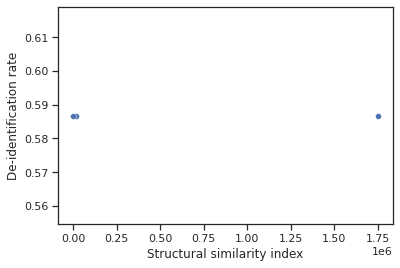

In [50]:
data = pd.DataFrame({'Structural similarity index': [loss_ssim_sv.item(), loss_ssim_ae.item(), loss_ssim_mean.item()],
                   'De-identification rate': [best_verif_acc, best_verif_acc, best_verif_acc]})
sns.scatterplot(data=data, x="Structural similarity index", y="De-identification rate");

## test

In [31]:
scales_vectors = np.array([torch_dataset.feature_scales[f] for f in range(len(required_params))])

sparse_rate = torch_dataset.sparse_rate
print('sparse_rate', sparse_rate)
L = 64
print('L', L)
# window = L * sparse_rate
window = 64
print('window', window)
step = 4
print('step', step)

sparse_rate 1
L 64
window 64
step 4


In [33]:
test_well = wells[22]
test_well

'well_17.json'

In [34]:
X_test = pd.DataFrame(logs[22]['data'], columns=[x['name'] for x in logs[22]['curves']])
X_test = X_test[required_params]
X_test = X_test.drop_duplicates()

In [36]:
y_name = 'DEPTH'
# X_test

In [37]:
def apply_window_transform(x, s, latent_noise_rate=0):
    x = x[np.arange(0, len(x), sparse_rate), :]
    mean_x = x.mean(axis=0)
    x = (x - mean_x)/s
    with torch.no_grad():
        x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
        z = generator_mean(x.transpose(1, 2))
    
    return z.transpose(1, 2)[0].cpu().data.numpy()*s + mean_x, z.transpose(1, 2)[0].cpu().data.numpy()

In [38]:
def apply_rolling_transform(X, w, scales, step=12):
    Z = []
    
    for i in tqdm(range(0, len(X) - w, step)):
        Z.append(apply_window_transform(X[i: i+w], scales))
        
    return Z

In [39]:
Z = apply_rolling_transform(X_test[required_params].values, window, scales_vectors, step)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:04<00:00, 200.89it/s]


837it [00:00, 194959.32it/s]
/tmp/ipykernel_28442/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 214167.43it/s]
/tmp/ipykernel_28442/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 182408.42it/s]
/tmp/ipykernel_28442/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 208457.48it/s]
/tmp/ipykernel_28442/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 206047.21it/s]
/tmp/ipykernel_28442/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)


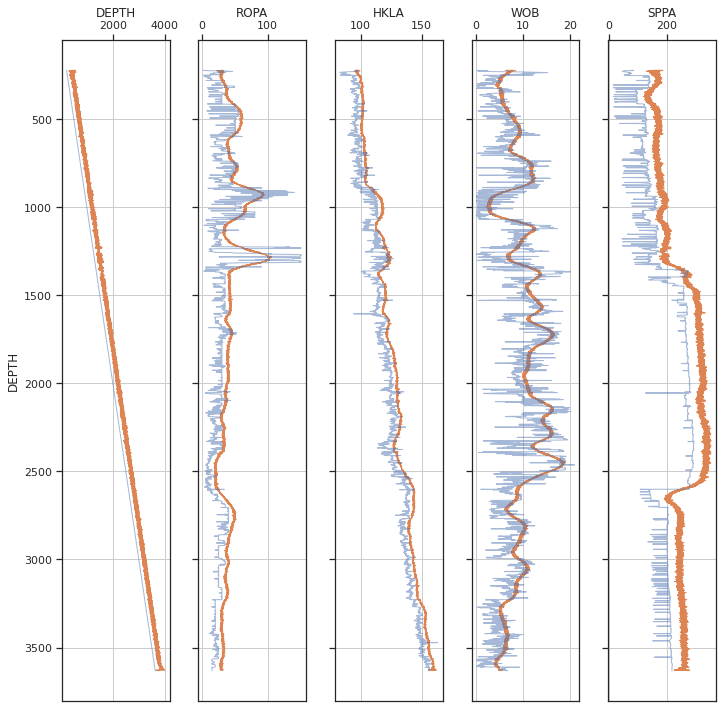

In [40]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)
#     for zi, x in tqdm(enumerate(range(0, len(df_well) - window, step))):
#         plt.plot(Z[zi][0][:, i], t[np.arange(x, x+window, sparse_rate)], color='C1', alpha=0.5, lw=0.5)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
    original.append(X_test[curve_name].astype(float).values)
    generated.append(A[not_nan_inds])
    
    plt.plot(A[not_nan_inds], t[not_nan_inds], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values, t, lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()


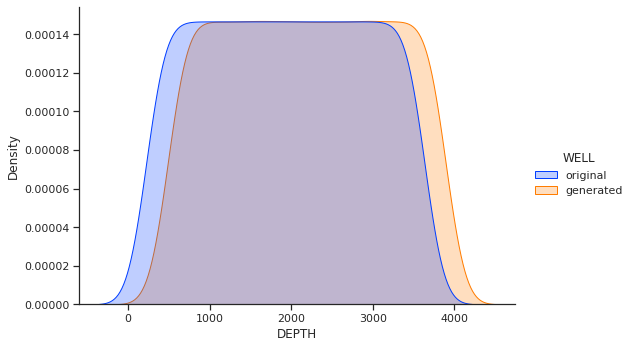

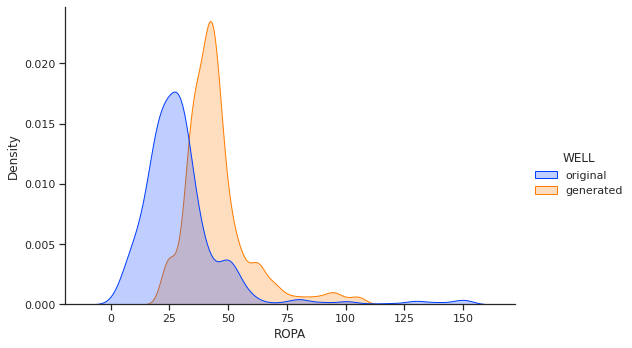

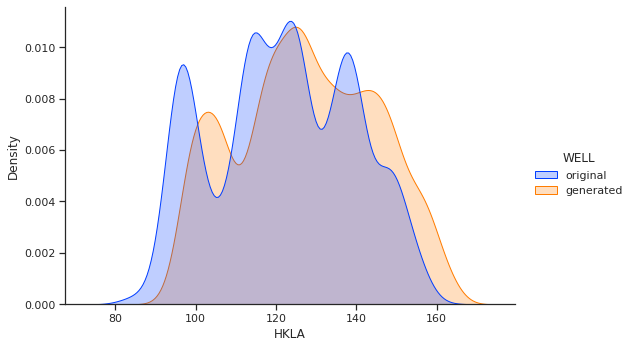

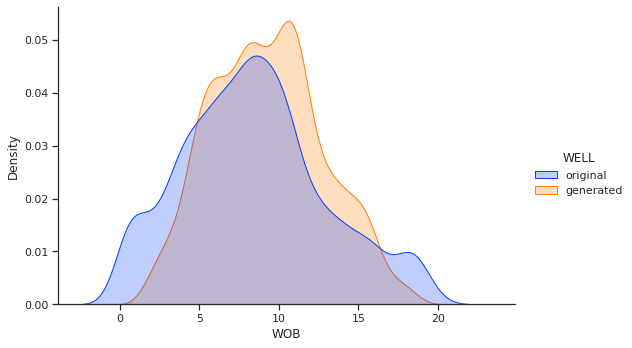

In [58]:
for i in required_params[:-1]:
    sns.displot(data=df_some, 
            x=i, hue='WELL', kind='kde',
            fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5
               )